Задача: написать несколько SQL-запросов в Jupyter Notebook. Необходимые данные находятся в таблицах схемы `stackoverflow`. 

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
#Создание подключения
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
# напишите запрос
query = '''
SELECT CAST(DATE_TRUNC('month', creation_date) AS date) AS month,
       SUM(views_count) AS sum
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY CAST(DATE_TRUNC('month', creation_date) AS date)
ORDER BY sum DESC;
'''

# выполните запрос
views_count = pd.read_sql_query(query, con=engine) 

In [5]:
views_count

,month,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


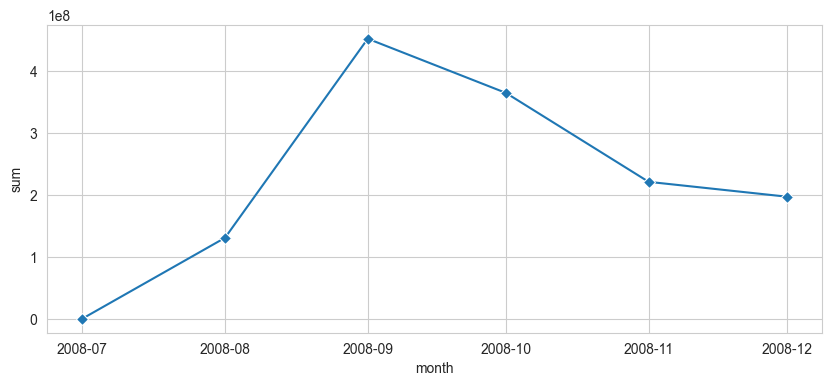

In [6]:
# применяем стиль whitegrid из библиотеки seaborn
sns.set_style('whitegrid')
# назначаем размер графика
plt.figure(figsize=(10, 4))
# строим линейный график средствами seaborn
sns.lineplot(x = 'month', y = 'sum', data=views_count, marker='D');

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Ответ: да, данные отличаются. Виден явный рост от июля 2008 года с пиком в августе и дальше идет постепенное снижение до ноября 2008 года, с ноября по декабрь почти стагнация.
БД - stackoverflow, возможно тестовые задания, вступительные экзамены во 2/3 волну поступающих в ВУЗы.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
SELECT display_name,
       COUNT(DISTINCT(user_id))
FROM stackoverflow.users AS u 
INNER JOIN stackoverflow.posts AS p ON u.id=p.user_id
INNER JOIN stackoverflow.post_types AS t ON p.post_type_id=t.id
WHERE (DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month') AND (p.post_type_id=2)
GROUP BY display_name
HAVING COUNT(p.id) > 100;
'''

# выполните запрос
active_users = pd.read_sql_query(query, con=engine) 

In [8]:
active_users

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


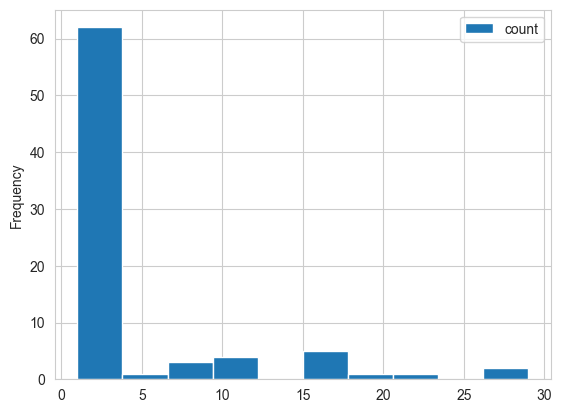

In [9]:
# Генерируем гистограмму
active_users.plot(kind='hist')
plt.show()

Гистограмма смещена вправо, существует ограничение на минимально возможное значение (1), но нет ограничения на максимально возможное значение (нет ограничения по активности пользователй).

In [10]:
#посмотрим на данные методом describe()
active_users.describe()

,count
count,79.000000
mean,3.987342
std,6.446016
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,29.000000


среднее значение 3,98, стандартное отклонение 6,44. Максимальное значение 29

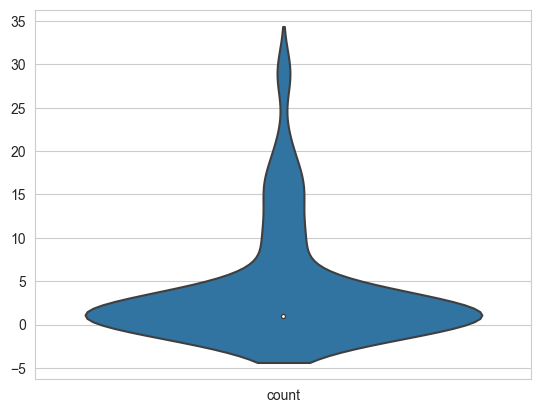

In [11]:
#визуализация выбросов
sns.violinplot(data = active_users); 

Какие аномалии наблюдаются в данных? О чём они говорят?

В данных есть аномально большие значения (при среднем значении 3,98, максимальное значение 29). Визуализация также подтверждает наличие аномально высоких начений.
Возможно часть ответов давали боты; воозможно пользователи доуточняли информацию и вместо 1й публикации, получалось 5-10 уточняющих.  

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [12]:
# напишите запрос
query = '''
WITH x AS 
    (SELECT u.id
    FROM stackoverflow.users AS u JOIN stackoverflow.posts AS p ON u.id=p.user_id
    WHERE (u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30')
    AND ((p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31'))
    GROUP BY u.id)

SELECT CAST(DATE_TRUNC('month', p.creation_date) AS date) AS month,
       COUNT(p.id) AS count
FROM stackoverflow.users AS u JOIN stackoverflow.posts AS p ON u.id=p.user_id
WHERE (p.creation_date::date BETWEEN '2008-01-01' AND '2008-12-31')
AND p.user_id IN (SELECT * FROM x)
GROUP BY CAST(DATE_TRUNC('month', p.creation_date) AS date)
ORDER BY CAST(DATE_TRUNC('month', p.creation_date) AS date) DESC;
'''

# выполните запрос
posts_per_month = pd.read_sql_query(query, con=engine) 

In [13]:
posts_per_month

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


In [14]:
#посмотрим на данные методом describe()
posts_per_month.describe()

,count
count,5.000000
mean,17601.600000
std,10648.648614
min,32.000000
25%,17641.000000
50%,18294.000000
75%,24870.000000
max,27171.000000


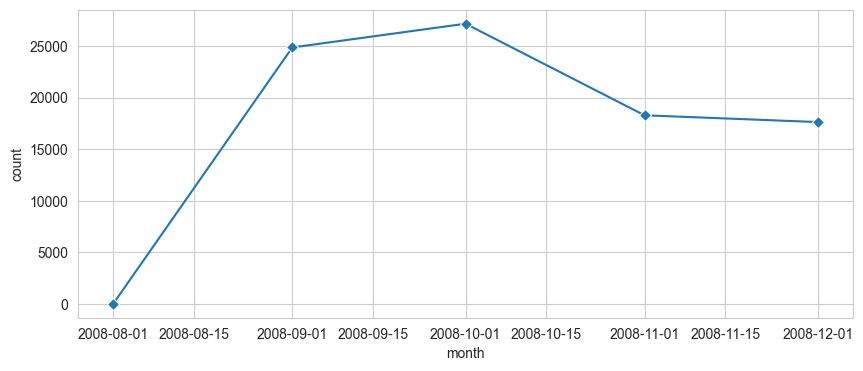

In [15]:
# посмотрим распределение по месяцам
# применяем стиль whitegrid из библиотеки seaborn
sns.set_style('whitegrid')
# назначаем размер графика
plt.figure(figsize=(10, 4))
# строим линейный график средствами seaborn
sns.lineplot(x = 'month', y = 'count', data = posts_per_month, marker = 'D');

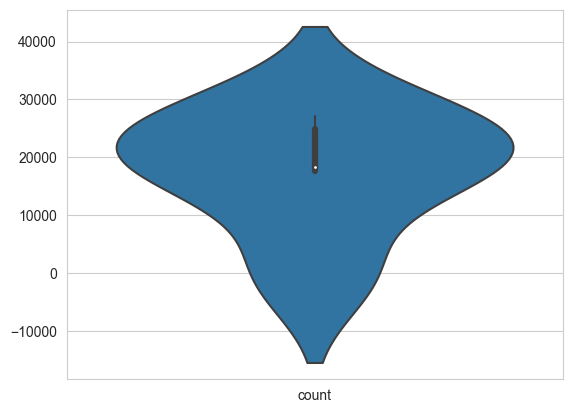

In [16]:
#визуализация выбросов
sns.violinplot(data = posts_per_month); 

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

аномально резкий рост/скачек в августе. Возможная причина: техническая ошибка при выгрузке данных; технический сбой, который привел с неверной дате поста

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [17]:
# напишите запрос
query = '''
SELECT user_id, 
       creation_date, 
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts 
ORDER BY user_id, creation_date;
'''

# выполните запрос
posts_info = pd.read_sql_query(query, con=engine) 

In [18]:
posts_info

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [19]:
# напишите запрос
query = '''
WITH x AS
    (SELECT p.user_id,
            DATE_TRUNC('day', p.creation_date)::date,
            COUNT(p.id)
     FROM stackoverflow.posts p
     WHERE user_id IN
          (SELECT user_id
           FROM stackoverflow.posts
           WHERE DATE_TRUNC('month', creation_date)::date BETWEEN '2008-08-01' AND '2008-08-31'
           GROUP BY user_id
           HAVING COUNT(id) > 120)
     GROUP BY p.user_id, DATE_TRUNC('day', p.creation_date)::date)
SELECT d.user_id,
       AVG(d.count)
FROM x AS d
WHERE DATE_TRUNC('month', d.date_trunc)::date BETWEEN '2008-08-01' AND '2008-08-31'
GROUP BY 1
ORDER BY 2;

'''

# выполните запрос
posts_avg = pd.read_sql_query(query, con=engine) 

In [20]:
posts_avg

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [21]:
# напишите запрос
query = '''
WITH x AS
    (SELECT user_id,
             COUNT(DISTINCT creation_date::date)  AS cnt
      FROM stackoverflow.posts
      WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07' 
      GROUP BY user_id)
SELECT ROUND(AVG(x.cnt)) AS result
FROM x

'''

# выполните запрос
avg = pd.read_sql_query(query, con=engine)

In [22]:
avg

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем 2 дня в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [23]:
# напишите запрос
query = '''
WITH x AS 
(SELECT user_id,
       creation_date,
       LAG(creation_date, 2) OVER(PARTITION BY user_id ORDER BY creation_date)::date AS lag
FROM stackoverflow.posts
ORDER BY user_id, creation_date)
SELECT user_id,
       creation_date,
       TO_CHAR(lag, 'Month') AS second_last_month   
FROM x
'''

# выполните запрос
activity_history = pd.read_sql_query(query, con=engine)

In [24]:
activity_history

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [25]:
# напишите запрос
query = '''
WITH profile AS
    (WITH x AS
        (SELECT DISTINCT user_id,
            FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER 
           (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) cohort_x
        FROM stackoverflow.posts)
SELECT *,
      COUNT(user_id) OVER(PARTITION BY cohort_x) AS cohort_users_cnt
FROM x),

sessions AS
    (SELECT user_id,
            DATE_TRUNC('month', creation_date) AS session_date
  FROM stackoverflow.posts
  GROUP BY user_id, creation_date)

SELECT p.cohort_x,
       s.session_date,
       COUNT(DISTINCT p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(DISTINCT p.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1, 2, 4;
'''

# выполните запрос
retention_rate = pd.read_sql_query(query, con=engine)

In [26]:
retention_rate

,cohort_x,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

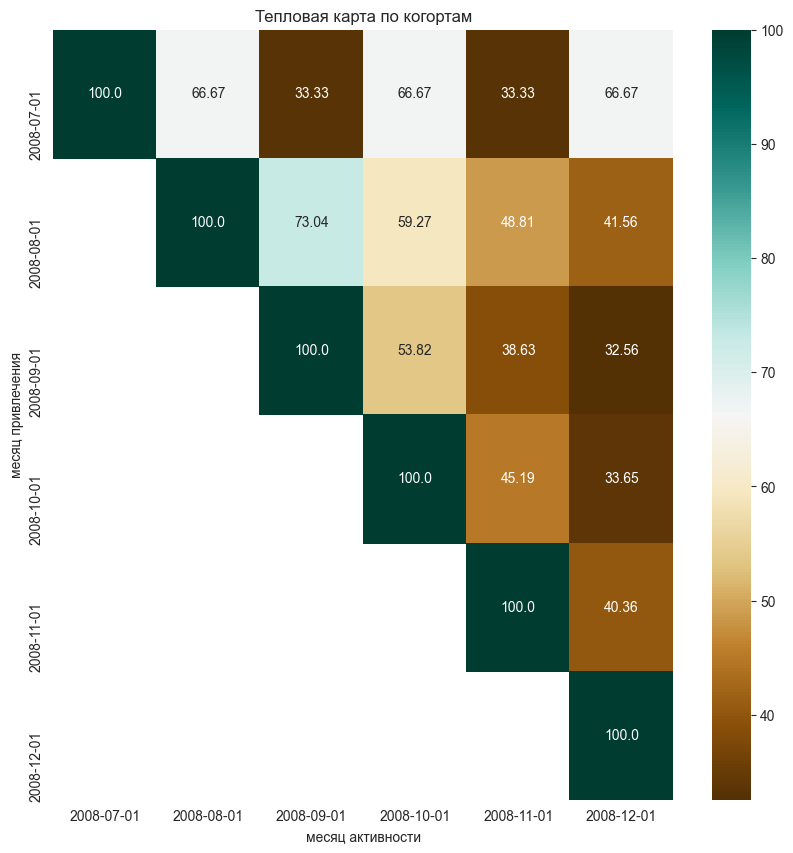

In [27]:
retention = retention_rate.pivot('cohort_x', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
plt.figure(figsize=(10, 10)) 
sns.heatmap(retention, 
            annot=True,
            cmap="BrBG",
            fmt='')
plt.xlabel('месяц активности')
plt.ylabel('месяц привлечения')
plt.title('Тепловая карта по когортам') 
plt.show()

Опишите аномалии или другие необычные явления и сформулируйте гипотезы:
    
    1) для когорты от 01-07-2008 года удержание постоянно то увеличивается, то снижается. В когорту попало всего 3 пользователя - вероятно результаты не очень показательны;
    2) для когорты от 01-08-2008 года и дальше удержание постепенно и постоянно снижается. 

Гипотеза: возможно, в это время появилось новое ПО, новая версия уже существующего ПО и кол-во запросов на StackOverflow увеличилось

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [28]:
# напишите запрос
query = '''
WITH x AS
    (SELECT ROUND(EXTRACT(MONTH from creation_date::date)) AS creation_month,
            COUNT(DISTINCT id)    
     FROM stackoverflow.posts
     WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
     GROUP BY EXTRACT(MONTH from creation_date::date))

SELECT *,
       ROUND(((count::numeric / LAG(count) OVER (ORDER BY creation_month)) - 1) * 100,2) AS percentage
FROM x;
'''

# выполните запрос
percentage_difference = pd.read_sql_query(query, con=engine)

In [29]:
percentage_difference

,creation_month,count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


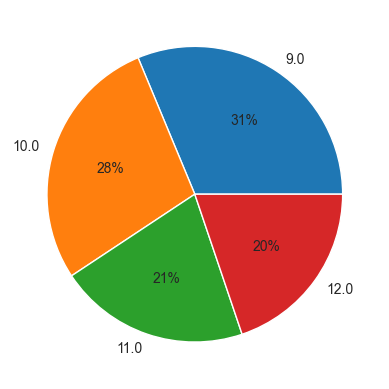

In [30]:
#строим piechart с количеством постов по месяцам
plt.pie(percentage_difference['count'], labels = percentage_difference['creation_month'], autopct='%.0f%%')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [31]:
# напишите запрос
query = '''
WITH x AS
    (SELECT user_id,
            COUNT(DISTINCT id) AS cnt
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY cnt DESC
    LIMIT 1),

     t AS
     (SELECT p.user_id,
             p.creation_date,
             EXTRACT('week' from p.creation_date) AS week_number
    FROM stackoverflow.posts AS p
    JOIN x ON x.user_id = p.user_id
    WHERE DATE_TRUNC('month', p.creation_date)::date BETWEEN '2008-10-01' AND '2008-10-31')

SELECT DISTINCT week_number::numeric,
       MAX(creation_date) OVER (PARTITION BY week_number) AS creation_date
FROM t
ORDER BY week_number;
'''


# выполните запрос
user_activities = pd.read_sql_query(query, con=engine)

In [32]:
user_activities

,week_number,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
